In [1]:
# Good Architecture Codes
import networkx as nx
import numpy as np

from qonstruct.code_builder.base import *
from qonstruct.code_builder.color_code import color_tanner_graph
from qonstruct.utils import binrref, row, null
from qonstruct.distance import compute_distance

In [2]:
# Helper functions
def tostr(mat: np.ndarray) -> str:
    s = ''
    if len(mat.shape) == 1:
        s = ''.join(['!' if x else '.' for x in mat])
    else:
        for r in mat:
            _r = ['!' if x else '.' for x in r]
            s += ''.join(_r) + '\n'
    return s

def assert_commuting(m1: np.ndarray, m2: np.ndarray, msg: str):
    for i in range(m1.shape[0]):
        r1 = m1[i]
        for j in range(m2.shape[0]):
            r2 = m2[j]
            r3 = np.logical_and(r1,r2)
            popcnt = sum([1 if x else 0 for x in r3])
            if popcnt % 2 == 1:
                print(f'[ {msg} ] anticommutation between rows:')
                for r in [r1,r2,r3]:
                    print('\t', tostr(r))

def to_tanner_graph(mat: np.ndarray) -> nx.Graph:
    basis1 = row(mat)
    assert_commuting(basis1,basis1,'basis1')
    basis2 = null(mat)
    assert_commuting(basis1,basis2,'basis1 vs basis2')
    M = np.concatenate((basis1, basis2), axis=0)
    _, pivots = binrref(M)
    # Create tanner graph
    gr = tanner_init()
    n, m = basis1.shape[1], basis1.shape[0]
    for i in range(n):
        add_data_qubit(gr, i)
    for i in range(m):
        for (j,typ) in enumerate(['x','z']):
            check = n + 2*i + j
            supp = [k for k in range(n) if basis1[i][k]]
            add_check(gr, check, typ, supp)
    # Add observables
    for _i in pivots:
        if _i < basis1.shape[0]:
            continue  # This means this pivot is a stabilizer
        i = _i - basis1.shape[0]
        obs = [j for j in range(n) if basis2[i,j]]
        for typ in ['x','z']:
            add_observable(gr, obs, typ)
    color_tanner_graph(gr)
    return gr

def get_params(gr: nx.Graph) -> tuple[int,int,int]:
    n = len(gr.graph['data_qubits'])
    k = len(gr.graph['data_qubits']) - len(gr.graph['checks']['all'])
    if k == 0:
        return 0,0,0
    d = compute_distance(gr, True)
    return n,k,d

def draw(gr: nx.Graph):
    COLOR_ARRAY = ['red', 'green', 'blue', 'yellow']
    SIZE = 100
    sizes = [ SIZE if 'color' in gr.nodes[x] else 10 for x in gr.nodes() ]
    colors = [ COLOR_ARRAY[gr.nodes[x]['color']] if 'color' in gr.nodes[x] else 'k' for x in gr.nodes() ]
    nx.draw_kamada_kawai(gr, node_size=sizes, node_color=colors)

In [3]:
## GRID-LIKE
def GL_adv(i, slen):
    if slen % 4 == 0:
        return (i+slen//2) % slen
    elif slen == 6:
        return (i+2) % 6

def GL_add_edge(gr, x: int, y: int, x_side: int, y_side: int):
    gr.add_edge(x,y)
    gr.nodes[x]['sides'][x_side] = y
    gr.nodes[y]['sides'][y_side] = x
    gr.graph['smap'][(x,y,y_side)] = x_side
    gr.graph['smap'][(y,x,x_side)] = y_side

def GL_dist(gr: nx.MultiGraph, a: int, b: int):
    ax, ay = gr.nodes[a]['coord']
    bx, by = gr.nodes[b]['coord']
    da, db = (ax-ay), (bx-by)
    if da > gr.graph['slen']/2:
        da = gr.graph['slen']-da
    if db > gr.graph['slen']/2:
        db = gr.graph['slen']-db
    return np.abs(da)**3 + np.abs(db)**3

def GL_sel_candidate(gr: nx.MultiGraph, root: int, cand_side: int) -> int:
    cand = []
    rc = gr.nodes[root]['color']
    rsides = gr.nodes[root]['sides']
    for x in gr.nodes():
        xc = gr.nodes[x]['color']
        if xc == rc:
            continue
        xsides = gr.nodes[x]['sides']
        if xsides[cand_side] != -1\
        or xsides[(cand_side-2)%len(xsides)] == root\
        or xsides[(cand_side+2)%len(xsides)] == root:
            continue
        cand.append(x)
    p = np.array([ 1.0/GL_dist(gr,root,x) for x in cand ])
    p /= p.sum()
    return None if len(cand) == 0 else np.random.choice(cand, p=p)

def GL_draw(gr: nx.MultiGraph):
    COLOR_ARRAY = ['red', 'green', 'blue']
    SIZE = 100
    colors = [ COLOR_ARRAY[gr.nodes[x]['color']] for x in gr.nodes() ]
    #pos = { x: gr.nodes[x]['coord'] for x in gr.nodes() }
    nx.draw_kamada_kawai(gr, node_size=SIZE, node_color=colors)

def GL_to_dual(gr: nx.MultiGraph):
    slen = gr.graph['slen']
    dual = nx.Graph()
    # Each data qubit is now a node. Two data qubits have an edge if they share
    # an edge in the tiling.
    k = 0
    qubit_map = {x: [-1 for _ in range(slen)] for x in gr.nodes()}
    for x in gr.nodes():
        for i in range(0, slen, 2):
            if qubit_map[x][i] != -1:
                continue  # already named.
            qubit_map[x][i], qubit_map[x][i+1] = k, k+1
            # Name connected check as well.
            y = gr.nodes[x]['sides'][i]
            j = GL_adv(i,slen)
            qubit_map[y][j], qubit_map[y][j+1] = k+1, k
            # Add edge.
            dual.add_edge(k, k+1)
            k += 2
        # Add edges on odd sides.
        for i in range(1, slen, 2):
            q1, q2 = qubit_map[x][i], qubit_map[x][(i+1) % slen]
            dual.add_edge(q1, q2, owner=(x,i))
    return dual
            
def GL_init(L1: int, L2: int, slen: int) -> nx.MultiGraph:
    gr = nx.MultiGraph()
    k = 0
    for i in range(L1):
        for j in range(L2):
            if np.random.random() < 0.3:
                continue
            color = 0 if (i+j) % 2 == 0 else 1
            gr.add_node( k, color=color, coord=(i,j), sides=[-1 for _ in range(slen)] )
            k += 1
    if gr.number_of_nodes() == 0:
        return None
    gr.graph['slen'] = slen
    gr.graph['smap'] = {}
    # Add random edges.
    remaining = list(gr.nodes())
    while len(remaining):
        ri = np.random.randint(0, len(remaining))
        x = remaining[ri]
        # Get candidate
        for sx in range(0, slen, 2):
            if gr.nodes[x]['sides'][sx] != -1:
                continue
            sy = GL_adv(sx,slen)
            y = GL_sel_candidate(gr, x, sy)
            if y is None:
                continue
            GL_add_edge(gr, x, y, sx, sy)
        del remaining[ri]
    return gr

def GL_add_blue_checks(gr: nx.MultiGraph):
    slen = gr.graph['slen']
    
    dual = GL_to_dual(gr)
    k = gr.number_of_nodes()
    for cyc in nx.simple_cycles(dual, max(8,slen)):
        if np.random.random() < 0.1:
            continue
        edges = []
        for i in range(len(cyc)):
            q1, q2 = cyc[i], cyc[(i+1)%len(cyc)]
            if 'owner' not in dual.edges[q1,q2]:
                continue
            edges.append(dual.edges[q1,q2]['owner'])  # This is a tuple (node,side) for use with gr.
        if len(edges) < 2 or len(edges) % 2 == 1:
            continue
        # Check if the check can be made (available edges in the corresponding checks).
        all_available = True
        for (x,xs) in edges:
            if gr.nodes[x]['sides'][xs] != -1:
                all_available = False
                break
        if not all_available:
            continue
        off = 1 if gr.nodes[edges[0][0]]['color'] == 1 else 0
        gr.add_node( k, color=2, sides=[-1 for _ in range(len(edges))] )
        for (i, (x,xs)) in enumerate(edges):
            GL_add_edge(gr, k, x, (i+off)%len(edges), xs)
        k += 1
    return gr

def GL_to_matrix(gr: nx.MultiGraph) -> np.ndarray:
    def tri(x,y,z,sx,sy,sz):
        arr = [x,y,z]
        tmp_map = {x: sx, y: sy, z: sz}
        arr.sort()
        return (arr[0], arr[1], arr[2], tmp_map[arr[0]], tmp_map[arr[1]], tmp_map[arr[2]])
    n = 0
    qubit_map = {}  # Each qubit is mapped to a triangle
    for x in gr.nodes():
        if gr.nodes[x]['color'] != 0:
            continue
        xsides = gr.nodes[x]['sides']
        for i in range(len(xsides)):
            y = xsides[i]
            z = xsides[(i+1)%len(xsides)]
            sy = -1 if y == -1 else gr.graph['smap'][(y,x,i)]
            sz = -1 if z == -1 else gr.graph['smap'][(z,x,(i+1)%len(xsides))]
            qubit_map[tri(x,y,z,i,sy,sz)] = n
            n += 1
    m = gr.number_of_nodes()
    mat = np.zeros((m,n), dtype=bool)
    for (tri, q) in qubit_map.items():
        x,y,z,_,_,_ = tri
        for row in [x,y,z]:
            if row != -1:
                mat[row][q] = True
    return mat

def GL_make_samples(s: int, L1: int, L2: int, slen: int) -> list[nx.MultiGraph]:
    samples = []
    n_empty = 0
    n_bad_init = 0
    n_bad_blues = 0
    for _ in range(s):
        gr = GL_init(L1, L2, slen)
        if gr is None:
            n_empty += 1
            continue
        # Validate this graph.
        is_good = True
        for x in gr.nodes():
            if gr.degree(x) < slen//2:
                is_good = False
                break
        if not is_good:
            n_bad_init += 1
            continue
        GL_add_blue_checks(gr)
        # Check that the code isnt immmediately distance 2
        is_good = True
        for x in gr.nodes():
            xsides = gr.nodes[x]['sides']
            for i in range(len(xsides)):
                if xsides[(i-1)%len(xsides)] == -1 and xsides[(i+1)%len(xsides)] == -1:
                    is_good = False
                    break
            if not is_good:
                break
        if is_good:
            samples.append(gr)
        else:
            n_bad_blues += 1
    print(f'n_empty = {n_empty}, n_bad_init = {n_bad_init}, n_bad_blues = {n_bad_blues}')
    return samples

In [57]:
samples = GL_make_samples(20000, 3, 4, 8)

n_empty = 0, n_bad_init = 17580, n_bad_blues = 933


In [61]:
# Get best sample
best_score = 0
best_sample_data = None
for gr in samples:
    H = GL_to_matrix(gr)
    tg = to_tanner_graph(H)
    n,k,d = get_params(tg)
    if d == 2:
        continue
    score = (k*d*d)/n
    if score > best_score:
        best_sample_data = (n,k,d,gr,H,tg,score)
print(best_sample_data is None)

False


best = [40, 10, 4]


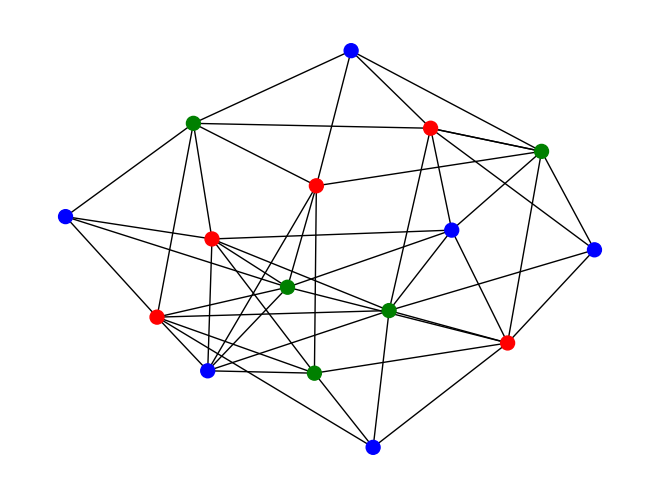

In [62]:
n,k,d,gr,_,tg,score = best_sample_data
print(f'best = [{n}, {k}, {d}]')
GL_draw(gr)

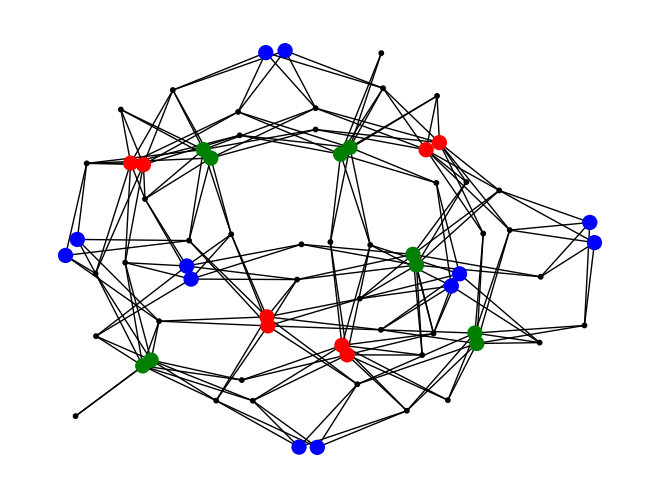

In [67]:
draw(tg)